In [2]:
from pylab import *
%matplotlib inline

In [7]:
caffe_root='/home/dagui/caffe-master/'
import sys

In [9]:
sys.path.insert(0,caffe_root+'python')
import caffe

In [10]:
import os

In [17]:
os.chdir(caffe_root)
os.chdir('examples')

In [18]:
from caffe import layers as L,params as P
def lenet(lmdb,batch_size):
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()
with open('mnist/my_lenet_train.prototxt','w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb',64)))
with open('mnist/my_lenet_test.prototxt','w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb',100)))

In [19]:
!cat mnist/my_lenet_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

In [20]:
!cat mnist/my_lenet_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/my_lenet_train.prototxt"
test_net: "mnist/my_lenet_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


In [23]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver=None
solver=caffe.SGDSolver('mnist/my_lenet_solver.prototxt')

In [25]:
[(k,v.data.shape) for k,v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [32]:
[(k,v[0].data.shape) for k,v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [33]:
solver.net.forward()
solver.test_nets[0].forward()

{'loss': array(2.375307083129883, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


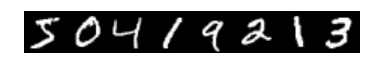

In [46]:
imshow(solver.net.blobs['data'].data[:8,0].transpose(1,0,2).reshape(28,8*28),cmap='gray');axis('off')
print 'train labels:',solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


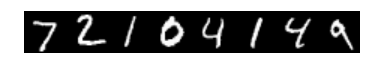

In [47]:


imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]



In [79]:
solver.step(1)

(-0.5, 24.5, 19.5, -0.5)

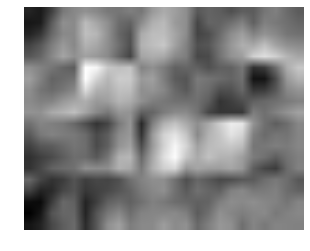

In [80]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

In [102]:
%%time
niter=200
test_interval=25
train_loss=zeros(niter)
test_acc=zeros(int(np.ceil(niter/test_interval)))
output=zeros((niter,8,10))
for it in range(niter):
    solver.step(1)
    train_loss[it]=solver.net.blobs['loss'].data
    solver.test_nets[0].forward(start='conv1')
    output[it]=solver.test_nets[0].blobs['score'].data[:8]
    if it% test_interval ==0:
        print 'Iteration',it,'testing...'
        correct=0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct+=sum(solver.test_nets[0].blobs['score'].data.argmax(1)==solver.test_nets[0].blobs['label'].data)
        test_acc[it//test_interval]=correct/1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 2.21 s, sys: 388 ms, total: 2.6 s
Wall time: 1.97 s


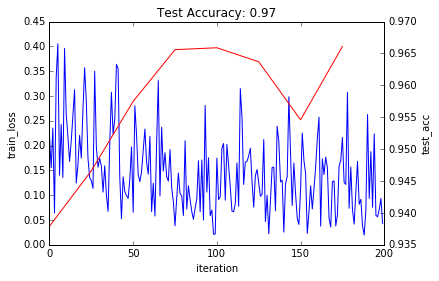

In [103]:
_,ax1=subplots()
ax2=ax1.twinx()
ax1.plot(arange(niter),train_loss)
ax2.plot(test_interval*arange(len(test_acc)),test_acc,'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train_loss')
ax2.set_ylabel('test_acc')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

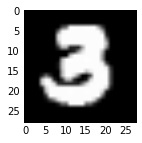

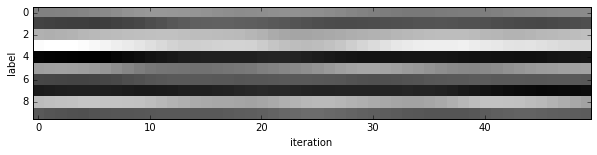

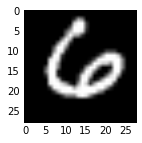

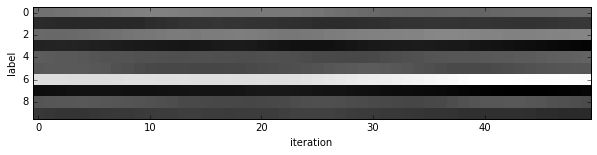

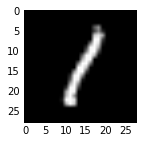

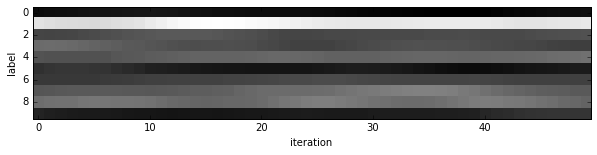

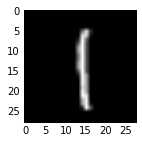

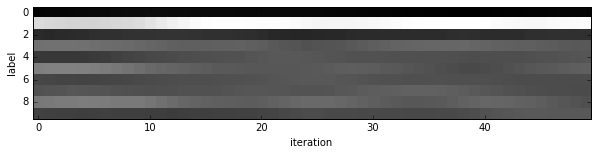

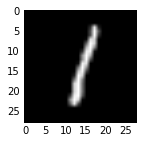

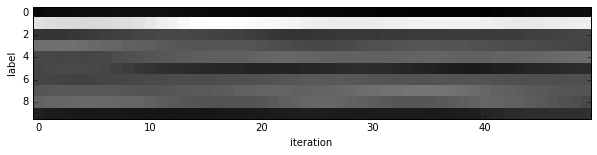

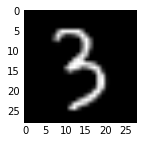

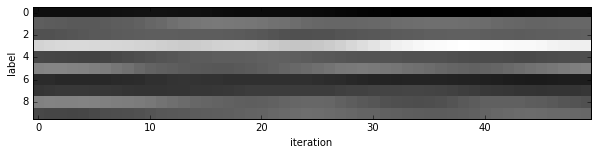

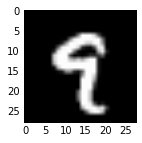

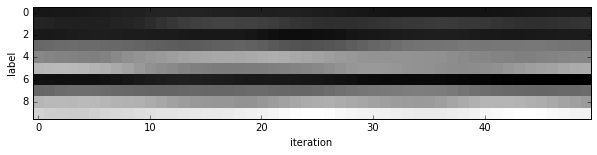

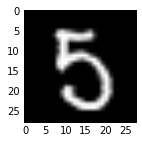

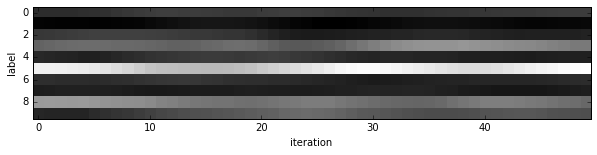

In [117]:
for i in range(8):
    figure(figsize=(2,2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

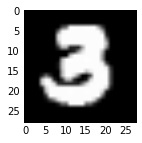

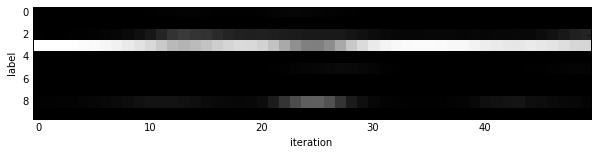

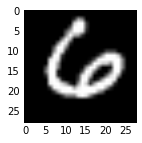

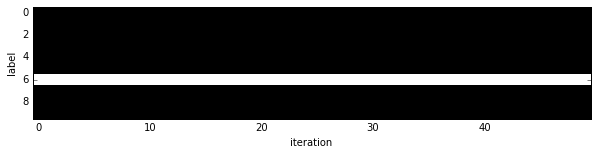

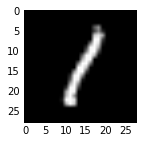

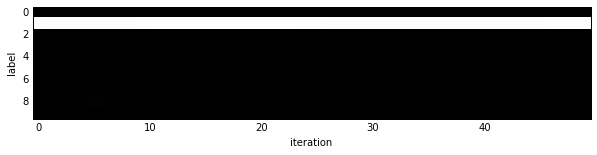

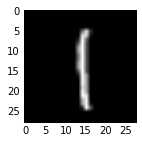

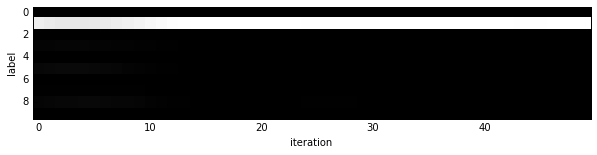

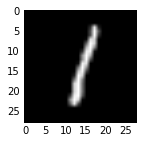

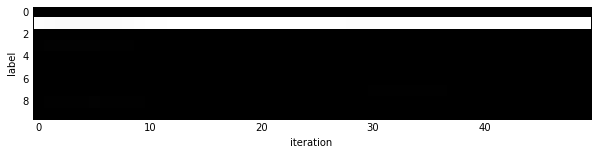

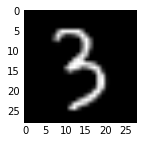

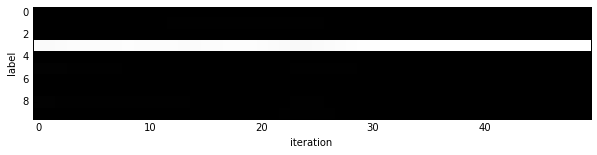

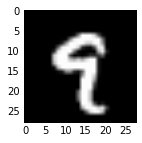

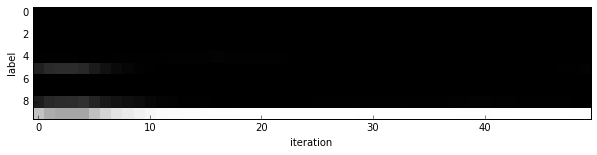

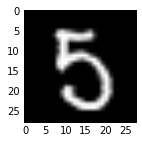

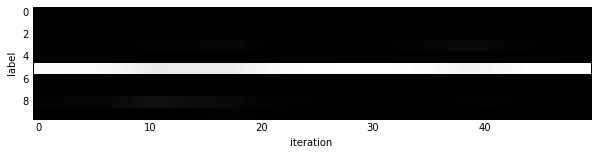

In [119]:


for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

